In [1]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from closed_circuit import *
from SALib.sample import sobol as sobol_sam
from tqdm import tqdm 
from p_tqdm import p_map
from SALib.analyze import sobol 
tv=ValveinP(1.06,2,6, # density, eff_length, Aann(cm2)
            0.3,0.4, # Kvo,Kvc
            0) #poc (mmHg)

t_end=25
t = [0,t_end]
t_step = 0.01
t_span = np.arange(0,t_end,t_step)
index_range = slice(2320, 2400)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]

problem = {
    'num_vars': 8,
    'names': ['Za_p', 'R_p','C_p','Za_s','R_s','C_s','leff_av','leff_pv'],
    'bounds': [[10, 200], [50, 500],[0.0005,0.01],[10, 500], [200, 5000],[0.0005,0.002],[1.5,2.5],[1,2.5]]
}
param_values =  sobol_sam.sample(problem, 32) 
#param_values = [[1.65110924e+02, 1.49198327e+02, 1.49817661e-03],
#       [1.29145957e+02, 1.49198327e+02, 1.49817661e-03],
#       [1.65110924e+02, 8.67822425e+01, 1.49817661e-03]]

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Assuming necessary imports and definitions for PressureSystem and dydt are already done
def compute_parameters(param):
    from closed_circuit import heart
    from closed_circuit import ValveinP
    from closed_circuit import PressureSystem
    rvef_param = []
    lvef_param = []
    sv_lv_param = []
    sv_rv_param = []
    p_lv_param_list = []
    p_rv_param_list = []
    p_pa_param_list = []
    p_ao_param_list = []
    v_lv_param_statistic = []
    v_rv_param_statistic = []
    q_av_list = []
    q_pv_list = []
    v_lv_list = []
    v_rv_list = []

    Za_p = param[0]
    R_p = param[1]
    C_p = param[2]
    cap_p = PressureSystem(C_p, Za_p, R_p)  # C,Za,R
    
    Za_s = param[3]
    R_s = param[4]
    C_s = param[5]
    
    cap_s = PressureSystem(C_s, Za_s, R_s)
    leff_av = param[6]
    leff_pv = param[7]
    #Aann_av = param[8]
    #Aann_pv = param[9]
    #Emin_rv = param[13]
    #Emax_rv = param[12]
    #Emin_lv = param[11]
    #Emax_lv = param[10]
    T = 0.8
    
    lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, # tau1,2 (s)
         m1 = 1.32, m2 = 27.4, # m1,2
         Emax = 3,Emin = 0.08, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)
    
    rv=heart(0.269*T,0.452*T, # tau1, 2
         1.32,27.4, # m1,2
         0.6,0.04, #Emax, min
         10,T=T) # Ks, V0 ,T
    
    la=heart(tau1 = 0.110*T, tau2 = 0.180*T, #tau1,2
         m1 = 1.32,m2 = 13.1, # m1,2
         Emax = 0.17, Emin = 0.08, #Emax,min(mmHg/mL)
         V0 = 3,T = T) # V0 (mL), T (s)
    ra=heart(0.110*T,0.180*T, # tau1, 2
         1.32,13.1, # m1,2
         0.15,0.04, # Emax,min
         3, T=T) # Ks, V0, T
    
    av=ValveinP(density = 1.06, eff_length = leff_av,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.12,Kvc = 0.15, # Kvo,Kvc
            p_oc = 0) #poc
    mv=ValveinP(density = 1.06,eff_length = 1.25,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.3,Kvc = 0.4, # Kvo,Kvc
            p_oc = 0) #poc
    pv=ValveinP(1.06,leff_pv,2.8, # density, eff_length, Aann(cm2)
            0.2,0.2, # Kvo,Kvc
            0) #poc 
    y_initial = np.array([135, 27,  # lv, la
                          150, 10,  # qav, qmv
                          0.01, 0.5,  # xi_av, xi_mv
                          5 * 1333,  # pa
                          180, 40,  # v_rv, v_ra
                          150, 10,  # q_tv, q_pv
                          0.01, 0.5,  # xi_tv, xi_pv
                          5 * 1333])  # pb
    # Integration
    def dydt(t,y):
        v_lv = y[0] 
        v_la = y[1]
        q_av = y[2]
        q_mv = y[3]
        xi_av = y[4]
        xi_mv = y[5]
        #pressure of capillaries in systemic circulation
        pa = y[6]
        v_rv = y[7]
        v_ra = y[8]
        q_tv = y[9]
        q_pv = y[10]
        xi_tv = y[11]
        xi_pv = y[12]
        #pressure of capillaries in pulmonary circulation
        pb = y[13]
        #calculate parameters
        #systemic
        p_la = la.p(v_la,t,0.85*T)
        p_lv = lv.p(v_lv,t)
        #p_aa: pressure at the coupling point of av and capillaries
        p_aa = cap_s.pi(q_av,pa)
        #pulmonary
        p_ra = ra.p(v_ra,t,0.85*T)
        p_rv = rv.p(v_rv,t)
        #q_cap2: flow out the capillaries of pulmonary circulation
        q_cap2 = cap_p.qout(pb,p_la)
        #p_pa: pressure at the coupling point of pv and capillaries
        p_pa = cap_p.pi(q_tv,pb)
        #q_cap1: flow out the capillaries of systemic circulation
        q_cap1 = cap_s.qout(pa,p_ra)
        #derivative
        #la
        dv_la = la.dv(t,v_la,q_cap2,q_mv)
        dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
        dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
        #lv
        dv_lv = lv.dv(t,v_lv,q_mv,q_av)
        dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
        dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
        #cap sys
        dpa = cap_s.dp(t,pa,q_av,p_ra)
        #ra
        dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
        dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
        dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
        #rv
        dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
        dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
        dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
        #cap pul
        dpb = cap_p.dp(t,pb,q_pv,p_la)
        #derivative vector
        dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
        return dy
    sol = sp.integrate.solve_ivp(dydt, t_span=t, y0=y_initial, t_eval=t_span, method='LSODA')
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    q_mv = sol.y[3]
    xi_av = sol.y[4]
    xi_mv = sol.y[5]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_tv = sol.y[9]
    q_pv = sol.y[10]
    xi_tv = sol.y[11]
    xi_pv = sol.y[12]
    pb = sol.y[13]

    p_pa = []
    p_rv = []
    p_ao = []
    p_lv = []
    for i, j in zip(sol.t[index_range], range(len(sol.t[index_range]))):
        p_pa.append(cap_p.pi(q_pv[j], pb[j]))
        p_ao.append(cap_p.pi(q_av[j], pa[j]))
        p_rv.append(rv.p(v_rv[j], i))
        p_lv.append(lv.p(v_lv[j], i))
    
    max_rv = max(sol.y[7][index_range])
    min_rv = min(sol.y[7][index_range])
    max_lv = max(sol.y[0][index_range])
    min_lv = min(sol.y[0][index_range])

    sv_rv = max_rv - min_rv
    sv_lv = max_lv - min_lv
    rvef = sv_rv / max_rv
    lvef = sv_lv / max_lv
    
    v_lv_err = []
    err_diff = v_lv[2300]-v_lv[2380]
    v_lv_err.append(err_diff)
    
    q_av_err = []
    err_diff = q_av[2300]-q_av[2380]
    q_av_err.append(err_diff)
    p_lv_param = [x / 1333 for x in p_lv]
    p_rv_param = [x / 1333 for x in p_rv]
    p_pa_param = [x / 1333 for x in p_pa]
    p_ao_param = [x / 1333 for x in p_ao]
    
    v_lv_list = v_lv[index_range]
    v_rv_list = v_rv[index_range]
    q_av_list = q_av[index_range]
    q_pv_list = q_pv[index_range]    
    

    return (sv_rv, sv_lv, rvef, lvef, p_lv_param, p_rv_param, p_pa_param, p_ao_param, v_lv_list, v_rv_list, q_av_list, q_pv_list,v_lv_err,q_av_err)

def main(param_values):
    results = p_map(compute_parameters, param_values, num_cpus=32)
    return results

if __name__ == "__main__":
    results = main(param_values)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [00:40<00:00, 14.19it/s]


In [3]:
sv_rv_param = []
sv_lv_param = []
rvef_param = []
lvef_param = []
p_lv_param_list = []
p_rv_param_list = []
p_pa_param_list = []
p_ao_param_list = []
v_lv_param_statistic = []
v_rv_param_statistic = []
q_av_list = []
q_pv_list = []
err_vlv = []
err_qav = []
for res in results:
    sv_rv_param.append(res[0])
    sv_lv_param.append(res[1])
    rvef_param.append(res[2])
    lvef_param.append(res[3])
    p_lv_param_list.append(res[4])
    p_rv_param_list.append(res[5])
    p_pa_param_list.append(res[6])
    p_ao_param_list.append(res[7])
    v_lv_param_statistic.append(res[8])
    v_rv_param_statistic.append(res[9])
    q_av_list.append(res[10])
    q_pv_list.append(res[11])
    err_vlv.append(res[12])
    err_qav.append(res[13])

In [4]:
p_lv_param_list = np.array(p_lv_param_list)
p_rv_param_list = np.array(p_rv_param_list)
p_pa_param_list = np.array(p_pa_param_list)
p_ao_param_list = np.array(p_ao_param_list)

In [5]:
q_av_list = np.array(q_av_list)
q_pa_list = np.array(q_pv_list)
v_lv_param_statistic = np.array(v_lv_param_statistic)
v_rv_param_statistic = np.array(v_rv_param_statistic)
sv_rv_param = np.array(sv_rv_param)
sv_lv_param = np.array(sv_lv_param)
rvef_param = np.array(rvef_param)
lvef_param = np.array(lvef_param)

In [6]:
n=len(p_lv_param_list)
p_lv_param_time = p_lv_param_list.T
p_rv_param_time = p_rv_param_list.T
p_pa_param_time = p_pa_param_list.T
p_ao_param_time = p_ao_param_list.T
v_rv_param_time = v_lv_param_statistic.T
v_lv_param_time = v_rv_param_statistic.T
q_av_list_time = q_av_list.T
q_pa_list_time = q_pa_list.T

In [7]:
S1_p_lv = []
S1_p_rv = []
S1_p_pa_param_list = []
S1_p_ao_param_list = []
S1_v_rv_param_statistic = []
S1_v_lv_param_statistic = []
ST_p_lv = []
ST_p_rv = []
ST_p_pa_param_list = []
ST_p_ao_param_list = []
ST_v_rv_param_statistic = []
ST_v_lv_param_statistic = []
S1_sv_rv_param = []
S1_sv_lv_param = []
S1_rvef_param = []
S1_lvef_param = []
ST_sv_rv_param = []
ST_sv_lv_param = []
ST_rvef_param = []
ST_lvef_param = []
S1_q_av = []
ST_q_av = []
S1_q_pv = []
ST_q_pv = []
S1_conf_plv = []
S1_conf_prv = []
ST_conf_plv = []
ST_conf_prv = []
S1_conf_ppa = []
ST_conf_ppa = []
S1_conf_pao = []
ST_conf_pao = []
S1_conf_vlv = []
S1_conf_vrv = []
S1_conf_qav = []
S1_conf_qpa = []
ST_conf_vlv = []
ST_conf_vrv = []
ST_conf_qav = []
ST_conf_qpa = []

In [8]:
def analyze_sobol(j):
    results = {}
    p_lv = sobol.analyze(problem, p_lv_param_time[j],calc_second_order=True)
    p_rv = sobol.analyze(problem, p_rv_param_time[j],calc_second_order=True)
    p_pa = sobol.analyze(problem, p_pa_param_time[j],calc_second_order=True)
    p_ao = sobol.analyze(problem, p_ao_param_time[j],calc_second_order=True)
    v_lv = sobol.analyze(problem, v_lv_param_time[j],calc_second_order=True)
    v_rv = sobol.analyze(problem, v_rv_param_time[j],calc_second_order=True)
    q_pa = sobol.analyze(problem, q_pa_list_time[j],calc_second_order=True)
    q_av = sobol.analyze(problem, q_av_list_time[j],calc_second_order=True)
    results['S1_p_lv'] = p_lv['S1']
    results['S1_p_rv'] = p_rv['S1']
    results['S1_conf_p_lv'] = p_lv['S1_conf']
    results['S1_conf_p_rv'] = p_rv['S1_conf']
    results['S1_p_pa_param_list'] = p_pa['S1']
    results['S1_p_ao_param_list'] = p_ao['S1']
    results['S1_conf_p_pa_param_list'] = p_pa['S1_conf']
    results['S1_conf_p_ao_param_list'] = p_ao['S1_conf']
    results['S1_v_rv_param_statistic'] = v_rv['S1']
    results['S1_v_lv_param_statistic'] = v_lv['S1']
    results['S1_conf_v_rv_param_statistic'] = v_rv['S1_conf']
    results['S1_conf_v_lv_param_statistic'] = v_lv['S1_conf']
    results['ST_p_lv'] = p_lv['ST']
    results['ST_p_rv'] = p_rv['ST']
    results['ST_conf_p_lv'] = p_lv['ST_conf']
    results['ST_conf_p_rv'] = p_rv['ST_conf']
    results['ST_p_pa_param_list'] = p_pa['ST']
    results['ST_p_ao_param_list'] = p_ao['ST']
    results['ST_conf_p_pa_param_list'] = p_pa['ST_conf']
    results['ST_conf_p_ao_param_list'] = p_ao['ST_conf']
    results['ST_v_rv_param_statistic'] = v_rv['ST']
    results['ST_v_lv_param_statistic'] = v_lv['ST']
    results['ST_conf_v_rv_param_statistic'] = v_rv['ST_conf']
    results['ST_conf_v_lv_param_statistic'] = v_lv['ST_conf']
    results['S1_q_pa'] = q_pa['S1']
    results['S1_conf_q_pa'] = q_pa['S1_conf']
    results['ST_q_pa'] = q_pa['ST']
    results['ST_conf_q_pa'] = q_pa['ST_conf']
    results['S1_conf_q_av'] = q_av['S1_conf']
    results['S1_q_av'] = q_av['S1']
    results['ST_q_av'] = q_av['ST']
    results['ST_conf_q_av'] = q_av['ST_conf']
    return results


count = range(0, index_range.stop - index_range.start)


results = p_map(analyze_sobol, count, num_cpus=32)


for result in results:
    S1_p_lv.append(result['S1_p_lv'])
    S1_p_rv.append(result['S1_p_rv'])
    S1_p_pa_param_list.append(result['S1_p_pa_param_list'])
    S1_p_ao_param_list.append(result['S1_p_ao_param_list'])
    S1_v_rv_param_statistic.append(result['S1_v_rv_param_statistic'])
    S1_v_lv_param_statistic.append(result['S1_v_lv_param_statistic'])
    ST_p_lv.append(result['ST_p_lv'])
    ST_p_rv.append(result['ST_p_rv'])
    ST_p_pa_param_list.append(result['ST_p_pa_param_list'])
    ST_p_ao_param_list.append(result['ST_p_ao_param_list'])
    ST_v_rv_param_statistic.append(result['ST_v_rv_param_statistic'])
    ST_v_lv_param_statistic.append(result['ST_v_lv_param_statistic'])
    S1_q_pv.append(result['S1_q_pa'])
    ST_q_pv.append(result['ST_q_pa'])
    S1_q_av.append(result['S1_q_av'])
    ST_q_av.append(result['ST_q_av'])
    S1_conf_plv.append(result['S1_conf_p_lv'])
    S1_conf_prv.append(result['S1_conf_p_rv'])
    ST_conf_plv.append(result['ST_conf_p_lv'])
    ST_conf_prv.append(result['ST_conf_p_rv'])
    S1_conf_ppa.append(result['S1_conf_p_pa_param_list'])
    ST_conf_ppa.append(result['ST_conf_p_pa_param_list'])
    S1_conf_pao.append(result['S1_conf_p_ao_param_list'])
    ST_conf_pao.append(result['ST_conf_p_ao_param_list'])
    S1_conf_vlv.append(result['S1_conf_v_lv_param_statistic'])
    S1_conf_vrv.append(result['S1_conf_v_rv_param_statistic'])
    S1_conf_qav.append(result['S1_conf_q_av'])
    S1_conf_qpa.append(result['S1_conf_q_pa'])
    ST_conf_vlv.append(result['ST_conf_v_lv_param_statistic'])
    ST_conf_vrv.append(result['ST_conf_v_rv_param_statistic'])
    ST_conf_qav.append(result['ST_conf_q_av'])
    ST_conf_qpa.append(result['ST_conf_q_pa'])

  0%|                                                                                                                                                                                                                                                                 | 0/80 [00:00<?, ?it/s]/home/shiting/.local/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/home/shiting/.local/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/home/shiting/.local/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated an

In [9]:
S1_sv_rv_param = []
S1_sv_lv_param = []
S1_rvef_param = []
S1_lvef_param = []
ST_sv_rv_param = []
ST_sv_lv_param = []
ST_rvef_param = []
ST_lvef_param = []
S_sv_rv_param = sobol.analyze(problem, sv_rv_param)
S1_sv_rv_param = S_sv_rv_param['S1']
ST_sv_rv_param = S_sv_rv_param['ST']
S_sv_lv_param = sobol.analyze(problem, sv_lv_param)
S1_sv_lv_param = S_sv_lv_param['S1']
ST_sv_lv_param = S_sv_lv_param['ST']
S_rvef_param = sobol.analyze(problem, rvef_param)
S1_rvef_param = S_rvef_param['S1']
ST_rvef_param = S_rvef_param['ST']
S_lvef_param = sobol.analyze(problem, lvef_param)
S1_lvef_param = S_lvef_param['S1']
ST_lvef_param = S_lvef_param['ST']

/home/shiting/.local/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


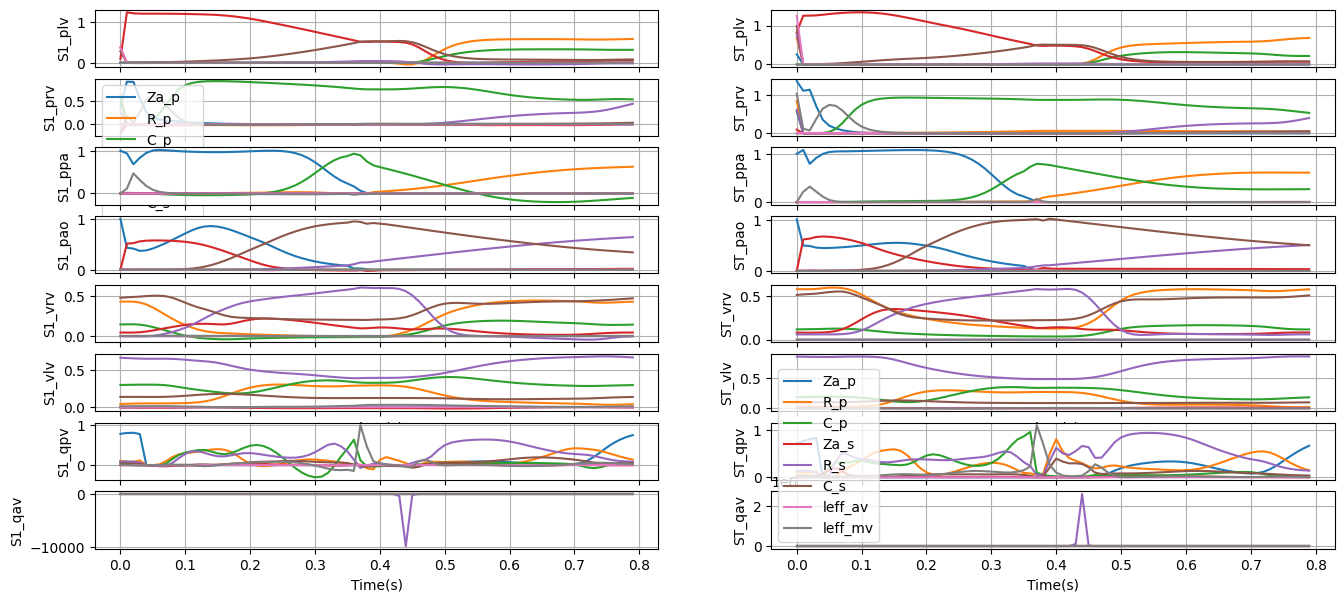

In [10]:
time = np.arange(0,0.8,0.01)
label = ['Za_p','R_p','C_p','Za_s','R_s','C_s','leff_av','leff_mv']
fig, axs = plt.subplots(8, 2, figsize=(16, 7),sharex=True) 
axs[0,0].plot(time, S1_p_lv, label =label)
axs[0,0].set_ylabel('S1_plv')

axs[0,0].grid()

axs[0,1].plot(time,ST_p_lv,label=label)
axs[0,1].set_ylabel('ST_plv')
axs[0,1].grid()


axs[1,0].plot(time, S1_p_rv, label =label)
axs[1,0].set_ylabel('S1_prv')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(time,ST_p_rv,label=label)
axs[1,1].set_ylabel('ST_prv')
axs[1,1].grid()


axs[2,0].plot(time, S1_p_pa_param_list, label =label)
axs[2,0].set_ylabel('S1_ppa')

axs[2,0].grid()

axs[2,1].plot(time,ST_p_pa_param_list,label=label)
axs[2,1].set_ylabel('ST_ppa')
axs[2,1].grid()


axs[3,0].plot(time, S1_p_ao_param_list, label =label)
axs[3,0].set_ylabel('S1_pao')

axs[3,0].grid()

axs[3,1].plot(time,ST_p_ao_param_list,label=label)
axs[3,1].set_ylabel('ST_pao')
axs[3,1].grid()


axs[4,0].plot(time, S1_v_rv_param_statistic, label =label)
axs[4,0].set_ylabel('S1_vrv')

axs[4,0].grid()

axs[4,1].plot(time,ST_v_rv_param_statistic,label=label)
axs[4,1].set_ylabel('ST_vrv')
axs[4,1].grid()


axs[5,0].plot(time, S1_v_lv_param_statistic, label =label)
axs[5,0].set_ylabel('S1_vlv')

axs[5,0].grid()
axs[5,0].set_xlabel('Time(s)')
axs[5,1].plot(time,ST_v_lv_param_statistic,label=label)
axs[5,1].set_ylabel('ST_vlv')
axs[5,1].grid()

axs[5,1].set_xlabel('Time(s)')
#plt.savefig('global_sensitivity.svg')

axs[6,0].plot(time, S1_q_pv, label =label)
axs[6,0].set_ylabel('S1_qpv')

axs[6,0].grid()
axs[6,0].set_xlabel('Time(s)')
axs[6,1].plot(time,ST_q_pv,label=label)
axs[6,1].set_ylabel('ST_qpv')
axs[6,1].grid()

axs[6,1].set_xlabel('Time(s)')

axs[7,0].plot(time, S1_q_av, label =label)
axs[7,0].set_ylabel('S1_qav')
axs[7,0].grid()
axs[7,0].set_xlabel('Time(s)')
axs[7,1].plot(time,ST_q_av,label=label)
axs[7,1].set_ylabel('ST_qav')
axs[7,1].grid()
axs[7,1].legend()
axs[7,1].set_xlabel('Time(s)')


plt.savefig('global_sensitivity.svg')
plt.show()


In [11]:
print('mean(err_vlv):',np.mean(err_vlv))
print('mean(err_qav):',np.mean(err_qav))
print('max_err_vlv',max(err_vlv))
print('max_err_qav',max(err_qav))

3.838481671879378e-05
3.200968518430926e-09
[0.015934850097536923]
[3.328725390823505e-07]


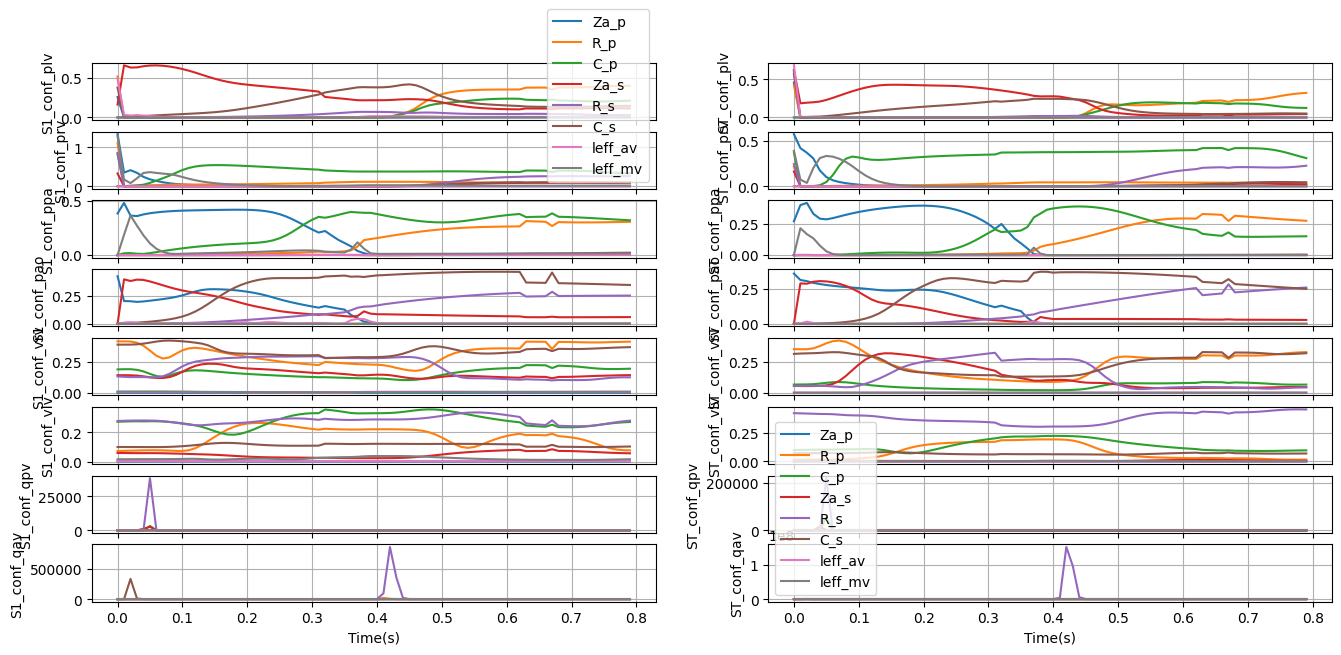

In [13]:
time = np.arange(0,0.8,0.01)
label = ['Za_p','R_p','C_p','Za_s','R_s','C_s','leff_av','leff_mv']
fig, axs = plt.subplots(8, 2, figsize=(16, 7),sharex=True) 
axs[0,0].plot(time,  S1_conf_plv, label =label)
axs[0,0].set_ylabel('S1_conf_plv')

axs[0,0].grid()

axs[0,1].plot(time,ST_conf_plv,label=label)
axs[0,1].set_ylabel('ST_conf_plv')
axs[0,1].grid()


axs[1,0].plot(time, S1_conf_prv, label =label)
axs[1,0].set_ylabel('S1_conf_prv')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(time,ST_conf_prv,label=label)
axs[1,1].set_ylabel('ST_conf_prv')
axs[1,1].grid()


axs[2,0].plot(time, S1_conf_ppa, label =label)
axs[2,0].set_ylabel('S1_conf_ppa')

axs[2,0].grid()

axs[2,1].plot(time,ST_conf_ppa,label=label)
axs[2,1].set_ylabel('ST_conf_ppa')
axs[2,1].grid()


axs[3,0].plot(time, S1_conf_pao, label =label)
axs[3,0].set_ylabel('S1_conf_pao')

axs[3,0].grid()

axs[3,1].plot(time,ST_conf_pao,label=label)
axs[3,1].set_ylabel('ST_conf_pao')
axs[3,1].grid()


axs[4,0].plot(time, S1_conf_vrv, label =label)
axs[4,0].set_ylabel('S1_conf_vrv')

axs[4,0].grid()

axs[4,1].plot(time,ST_conf_vrv,label=label)
axs[4,1].set_ylabel('ST_conf_vrv')
axs[4,1].grid()


axs[5,0].plot(time, S1_conf_vlv, label =label)
axs[5,0].set_ylabel('S1_conf_vlv')

axs[5,0].grid()
axs[5,0].set_xlabel('Time(s)')
axs[5,1].plot(time,ST_conf_vlv,label=label)
axs[5,1].set_ylabel('ST_conf_vlv')
axs[5,1].grid()

axs[5,1].set_xlabel('Time(s)')
#plt.savefig('global_sensitivity.svg')

axs[6,0].plot(time, S1_conf_qpa, label =label)
axs[6,0].set_ylabel('S1_conf_qpv')

axs[6,0].grid()
axs[6,0].set_xlabel('Time(s)')
axs[6,1].plot(time,ST_conf_qpa,label=label)
axs[6,1].set_ylabel('ST_conf_qpv')
axs[6,1].grid()

axs[6,1].set_xlabel('Time(s)')

axs[7,0].plot(time, S1_conf_qav, label =label)
axs[7,0].set_ylabel('S1_conf_qav')
axs[7,0].grid()
axs[7,0].set_xlabel('Time(s)')
axs[7,1].plot(time,ST_conf_qav,label=label)
axs[7,1].set_ylabel('ST_conf_qav')
axs[7,1].grid()
axs[7,1].legend()
axs[7,1].set_xlabel('Time(s)')


plt.savefig('global_sensitivity_conf.svg')
plt.show()